# Alice & Bob: FTQC Simulations for Cat-Qubit Architectures Internship

# Simulating the Code Capacity Model of the Cat Code Under Photon Loss and Dephasing on a Kerr-Cat Qubit

In [203]:
!pip install qutip --quiet

import numpy as np
import matplotlib.pyplot as plt
from qutip import coherent, destroy, mesolve, ket2dm, qeye, fidelity

The coherent state $|\alpha\rangle$ is a special state of bosonic systems and the quantum harmonic oscillator (QHO) whose quantization shares an equivalent structure with bosons. Expanded in the eigenstates of the QHO—otherwise referred to as the Fock basis—$|\alpha\rangle=e^{-|\alpha|^2/2}\sum_{n=0}^{\infty}\frac{\alpha^n}{\sqrt{n!}}|n\rangle$ where $\alpha=2$ is the optimal coherent state amplitude for most simulations. In numerical simulation, the upper bound $N$ of this sum must be finite. Therefore, motivated by the statistical relationship $N\geq|\alpha|^2+5|\alpha|$, the sum is truncated after $N=15$ elements.

In [204]:
alpha = 2
N = 15

coh = coherent(N, alpha)
neg_coh = coherent(N, -alpha)

The mean photon loss number is $\gamma_\kappa=\kappa|\alpha|^2t$—the product of the photon loss rate $\kappa$, $\alpha$, and evolution time $t$. An appropriate range is $\gamma_\kappa\in[10^{-3},1]$. Moreover, the dephasing parameter is evaluated at values $\gamma_\phi\in[0, 3.33, 6.67, 10]$.

In [205]:
photon_loss_vals = np.logspace(-3, 0, 10)
dephasing_vals = [0, 3.33, 6.67, 10]
t = 1

A Kerr-Cat qubit encodes the same amplitude twice but with opposite phases, trading off an exponential decrease in bit flip errors and a linear increase in phase flip errors. It's Hamiltonian is given by the sum of the Kerr nonlinearity and two-photon drive terms—$H=H_{\text{Kerr}}+H_{\text{drive}}=Ka^{\dagger^2}a^2+\epsilon(a^{\dagger^2}+a^2)$. Assuming the condition $\epsilon=-K|\alpha|^2$, the approximate, normalized eigenstates of this Hamiltonian are $|\text{Cat}_\pm\rangle=𝒩_\pm(|\alpha\rangle\pm|-\alpha\rangle)$. These cat states grow exponentially close to the real eigenstates in $\alpha$. In this simulation, $K=1$.

In [206]:
a = destroy(N)
H = a.dag()**2 * a**2 - alpha**2 * (a.dag()**2 + a**2)

cat_0 = (coh + neg_coh).unit()
cat_1 = (coh - neg_coh).unit()

Now, **mesolve()** is used to determine how the logical encoding $|0_L\rangle=|\text{Cat}_+\rangle$ evolves under the Lindblad master equation $\frac{d\rho}{dt}=-i[H,\rho]+\sum_kL_k\rho L_k^\dagger -\frac{1}{2}\{L_k L_k^\dagger,\rho\}$ with Lindblad operators $L_\kappa=\sqrt{\kappa}a$ and $L_\phi=\sqrt{\phi}a^{\dagger}a$ representing photon loss and dephasing noise, respectively. This result is projected into the code space, and the probability of measuring $|1_L\rangle=|\text{Cat}_-\rangle$ is the logical error rate $p_L$.

In [207]:
logical_errors = []

for dephasing_rate in dephasing_vals:
    error_rates = []
    for photon_loss_rate in photon_loss_vals:
        c_ops = [np.sqrt(photon_loss_rate) * a, np.sqrt(dephasing_rate) * a.dag() * a]

        result = mesolve(H, ket2dm(cat_0), tlist=[0, t], c_ops=c_ops)
        final_state = result.states[-1]

        proj_0 = ket2dm(cat_0)
        proj_1 = ket2dm(cat_1)
        proj = proj_0 + proj_1

        proj_state = (proj * final_state * proj).unit()
        error_rate = (proj_1 * proj_state).tr().real

        error_rates.append(error_rate)
    logical_errors.append(error_rates)


The code capacity model assumes perfect syndrome extraction and recovery, so these steps aren't shown in this simulation. The plot of logical error rate $p_L$ vs. mean photon loss $\gamma_\kappa$ at different dephasing rates is illustrated below.

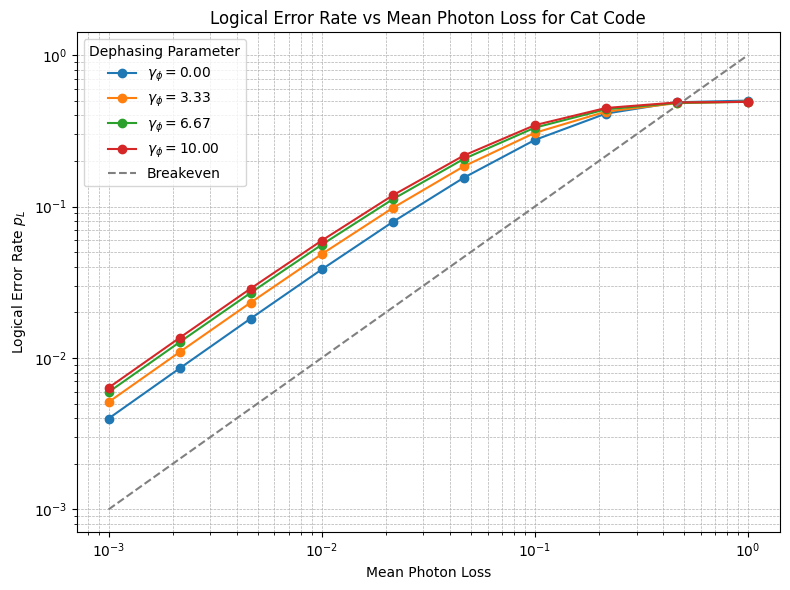

In [208]:
plt.figure(figsize=(8, 6))

for i, dephasing_rate in enumerate(dephasing_vals):
    plt.loglog(photon_loss_vals, logical_errors[i], marker='o', label=rf"$\gamma_\phi = {dephasing_rate:.2f}$")
plt.loglog(photon_loss_vals, photon_loss_vals, linestyle='--', color='gray', label="Breakeven")

plt.xlabel(r"Mean Photon Loss")
plt.ylabel(r"Logical Error Rate $p_L$")
plt.title("Logical Error Rate vs Mean Photon Loss for Cat Code")
plt.legend(title=r"Dephasing Parameter")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.show()